# Loading and Using RL Models from rl_og

This notebook demonstrates how to load and use the trained RL models (PPO, A2C, DQN) from the `rl_og/RL_data/` directory.


## Setup and Imports


In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path to import rl_og modules
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "rl_og"))

# Import stable-baselines3 models
from stable_baselines3 import PPO, A2C, DQN

# Import the Bank environment and players
from rl_og.bank_gym import BankEnv
from rl_og.players import ThersholdPlayer, GreedyPlayer, GreedyPlayerK, SesquaGreedyPlayer

import numpy as np
import matplotlib.pyplot as plt


## Define Model Paths


In [2]:
# Path to the RL data directory
rl_data_path = project_root / "rl_og" / "RL_data"

# Model file paths
ppo_model_path = rl_data_path / "rl_bank_model_ppo.zip"
a2c_model_path = rl_data_path / "rl_bank_model_a2c.zip"
dqn_model_path = rl_data_path / "rl_bank_model_dqn.zip"

print(f"PPO model path: {ppo_model_path}")
print(f"A2C model path: {a2c_model_path}")
print(f"DQN model path: {dqn_model_path}")

# Check if models exist
print(f"\nPPO model exists: {ppo_model_path.exists()}")
print(f"A2C model exists: {a2c_model_path.exists()}")
print(f"DQN model exists: {dqn_model_path.exists()}")


PPO model path: /home/normski/Code/Projects/Bank_Analysis/rl_og/RL_data/rl_bank_model_ppo.zip
A2C model path: /home/normski/Code/Projects/Bank_Analysis/rl_og/RL_data/rl_bank_model_a2c.zip
DQN model path: /home/normski/Code/Projects/Bank_Analysis/rl_og/RL_data/rl_bank_model_dqn.zip

PPO model exists: True
A2C model exists: True
DQN model exists: True


## Create Environment

The environment must match the one used during training. Based on the training script, it uses:
- 10 rounds
- ThresholdPlayer(threshold=100) as opponent
- max_round_length=100


In [3]:
# Create environment matching training configuration
opponents = [ThersholdPlayer(threshold=100)]

env = BankEnv(
    rounds=10,
    opponents=opponents,
    max_round_length=100,
    verbose=False
)

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")


Observation space: Box(-inf, inf, (6,), float32)
Action space: Discrete(2)


## Load Models

Load each model type. Note: When loading, you need to specify the algorithm class and the environment.


In [4]:
# Load PPO model
if ppo_model_path.exists():
    ppo_model = PPO.load(str(ppo_model_path), env=env)
    print("✓ PPO model loaded successfully")
else:
    ppo_model = None
    print("✗ PPO model not found")

# Load A2C model
if a2c_model_path.exists():
    a2c_model = A2C.load(str(a2c_model_path), env=env)
    print("✓ A2C model loaded successfully")
else:
    a2c_model = None
    print("✗ A2C model not found")

# Load DQN model
if dqn_model_path.exists():
    dqn_model = DQN.load(str(dqn_model_path), env=env)
    print("✓ DQN model loaded successfully")
else:
    dqn_model = None
    print("✗ DQN model not found")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ PPO model loaded successfully
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ A2C model loaded successfully
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ DQN model loaded successfully


## Example: Run a Single Episode with a Model

This function demonstrates how to use a loaded model to play a single game.


In [14]:
def run_episode(model, env, render=False):
    """
    Run a single episode with the given model.
    
    Args:
        model: The loaded RL model (PPO, A2C, or DQN)
        env: The BankEnv environment
        render: Whether to print game state during play
    
    Returns:
        final_scores: List of final scores [agent_score, opponent1_score, ...]
        total_reward: Total reward accumulated during the episode
        step_count: Number of steps taken
    """
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    step_count = 0
    
    while not (terminated or truncated):
        # Get action from model (deterministic=True for evaluation)
        action, _ = model.predict(obs, deterministic=True)
        
        # Take step in environment
        obs, reward, terminated, truncated, info = env.step(action)
        
        total_reward += reward
        step_count += 1
        
        if render and step_count % 5 == 0:
            print(f"Step {step_count}: Current score = {info.get('current_score', 0)}, "
                  f"Player scores = {info.get('player_scores', [])}")
    
    # Get final scores
    final_scores = info.get('final_scores', info.get('player_scores', []))
    
    return final_scores, total_reward, step_count

# Example: Run one episode with PPO model
if ppo_model is not None:
    print("Running one episode with PPO model:")
    final_scores, reward, steps = run_episode(ppo_model, env, render=True)
    print(f"\nFinal scores: {final_scores}")
    print(f"Total reward: {reward:.2f}")
    print(f"Total steps: {steps}")
    print(f"Agent {'won' if final_scores[0] > max(final_scores[1:]) else 'lost' if final_scores[0] < max(final_scores[1:]) else 'tied'}")


Running one episode with PPO model:
Step 5: Current score = 21, Player scores = [104, 101]
Step 10: Current score = 97, Player scores = [104, 101]
Step 15: Current score = 33, Player scores = [216, 204]
Step 20: Current score = 32, Player scores = [370, 352]
Step 25: Current score = 62, Player scores = [370, 352]
Step 30: Current score = 20, Player scores = [370, 352]
Step 35: Current score = 0, Player scores = []

Final scores: [370, 352]
Total reward: 1.00
Total steps: 35
Agent won


## Evaluate Model Performance

Evaluate a model over multiple episodes to get statistics.


In [15]:
def evaluate_model(model, env, n_episodes=100):
    """
    Evaluate a model over multiple episodes.
    
    Returns:
        win_rate: Fraction of games won
        avg_score: Average final score
        episode_results: List of results (1=win, 0=tie, -1=loss)
        episode_scores: List of final scores
    """
    wins = 0
    ties = 0
    losses = 0
    total_score = 0
    episode_results = []
    episode_scores = []
    
    for episode in range(n_episodes):
        final_scores, _, _ = run_episode(model, env, render=False)
        
        agent_score = final_scores[0]
        opponent_scores = final_scores[1:] if len(final_scores) > 1 else [0]
        max_opponent_score = max(opponent_scores) if opponent_scores else 0
        
        total_score += agent_score
        episode_scores.append(agent_score)
        
        if agent_score > max_opponent_score:
            wins += 1
            episode_results.append(1)
        elif agent_score == max_opponent_score:
            ties += 1
            episode_results.append(0)
        else:
            losses += 1
            episode_results.append(-1)
    
    win_rate = wins / n_episodes
    avg_score = total_score / n_episodes
    
    return win_rate, avg_score, episode_results, episode_scores

# Evaluate PPO model
if ppo_model is not None:
    print("Evaluating PPO model over 100 episodes...")
    ppo_win_rate, ppo_avg_score, ppo_results, ppo_scores = evaluate_model(ppo_model, env, n_episodes=100)
    print(f"PPO Win Rate: {ppo_win_rate:.3f} ({ppo_win_rate*100:.1f}%)")
    print(f"PPO Average Score: {ppo_avg_score:.2f}")
    print(f"Wins: {sum(1 for r in ppo_results if r == 1)}, "
          f"Ties: {sum(1 for r in ppo_results if r == 0)}, "
          f"Losses: {sum(1 for r in ppo_results if r == -1)}")


Evaluating PPO model over 100 episodes...
PPO Win Rate: 0.670 (67.0%)
PPO Average Score: 609.08
Wins: 67, Ties: 0, Losses: 33


## Compare All Models

Compare the performance of all three models.


In [16]:
# Evaluate all available models
models_to_evaluate = []
if ppo_model is not None:
    models_to_evaluate.append(("PPO", ppo_model))
if a2c_model is not None:
    models_to_evaluate.append(("A2C", a2c_model))
if dqn_model is not None:
    models_to_evaluate.append(("DQN", dqn_model))

results = {}
n_eval_episodes = 100

for model_name, model in models_to_evaluate:
    print(f"\nEvaluating {model_name}...")
    win_rate, avg_score, episode_results, episode_scores = evaluate_model(
        model, env, n_episodes=n_eval_episodes
    )
    results[model_name] = {
        'win_rate': win_rate,
        'avg_score': avg_score,
        'episode_results': episode_results,
        'episode_scores': episode_scores
    }
    print(f"  Win Rate: {win_rate:.3f}")
    print(f"  Avg Score: {avg_score:.2f}")

# Print comparison
print("\n" + "="*60)
print("Model Comparison")
print("="*60)
for model_name, result in results.items():
    print(f"{model_name:6s}: Win Rate = {result['win_rate']:.3f}, "
          f"Avg Score = {result['avg_score']:.2f}")



Evaluating PPO...
  Win Rate: 0.780
  Avg Score: 690.08

Evaluating A2C...
  Win Rate: 0.610
  Avg Score: 691.33

Evaluating DQN...
  Win Rate: 0.800
  Avg Score: 759.82

Model Comparison
PPO   : Win Rate = 0.780, Avg Score = 690.08
A2C   : Win Rate = 0.610, Avg Score = 691.33
DQN   : Win Rate = 0.800, Avg Score = 759.82


## Visualize Results


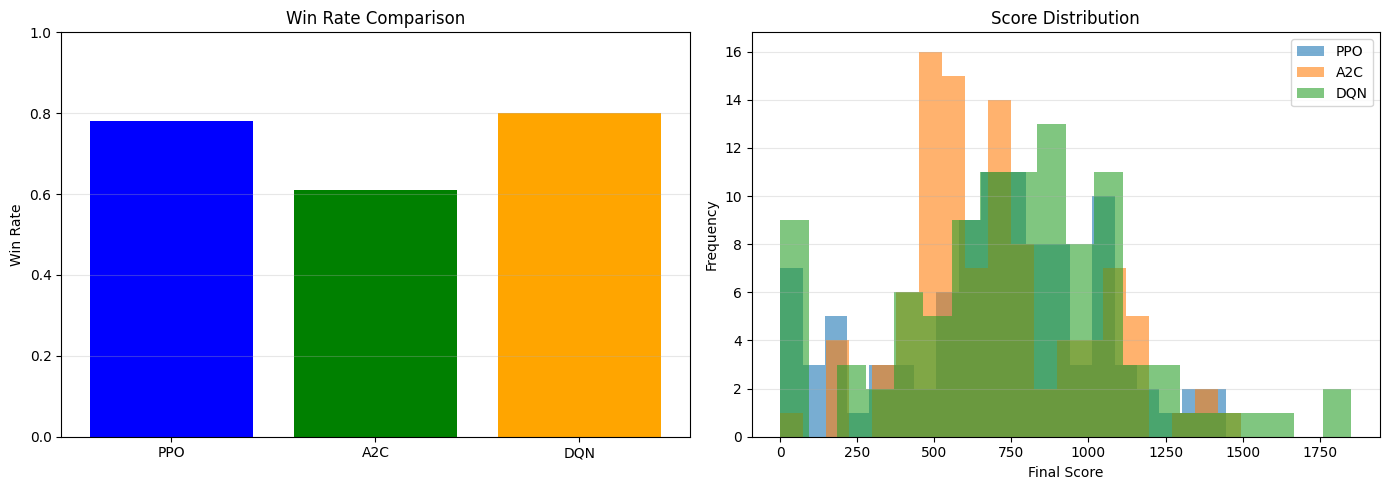

In [17]:
if results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Win rate comparison
    ax1 = axes[0]
    model_names = list(results.keys())
    win_rates = [results[m]['win_rate'] for m in model_names]
    ax1.bar(model_names, win_rates, color=['blue', 'green', 'orange'][:len(model_names)])
    ax1.set_ylabel('Win Rate')
    ax1.set_title('Win Rate Comparison')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Score distribution
    ax2 = axes[1]
    for model_name, result in results.items():
        ax2.hist(result['episode_scores'], alpha=0.6, label=model_name, bins=20)
    ax2.set_xlabel('Final Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## Use Models with Different Opponents

You can also test the models against different opponents by creating a new environment.


In [18]:
# Test against different opponents
if ppo_model is not None:
    print("Testing PPO model against different opponents:\n")
    
    different_opponents = [
        ("Threshold(50)", [ThersholdPlayer(threshold=50)]),
        ("Threshold(100)", [ThersholdPlayer(threshold=100)]),
        ("GreedyPlayer", [GreedyPlayer()]),
        ("GreedyPlayerK(2)", [GreedyPlayerK(k=2)]),
    ]
    
    for opp_name, opponents in different_opponents:
        # Create new environment with different opponents
        test_env = BankEnv(
            rounds=10,
            opponents=opponents,
            max_round_length=100,
            verbose=False
        )
        
        # Note: You may need to reload the model with the new environment
        # or use model.set_env(test_env)
        ppo_model.set_env(test_env)
        
        win_rate, avg_score, _, _ = evaluate_model(ppo_model, test_env, n_episodes=50)
        print(f"  vs {opp_name:20s}: Win Rate = {win_rate:.3f}, Avg Score = {avg_score:.2f}")
        
        test_env.close()
    
    # Reset to original environment
    ppo_model.set_env(env)


Testing PPO model against different opponents:

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
  vs Threshold(50)       : Win Rate = 0.720, Avg Score = 621.04
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
  vs Threshold(100)      : Win Rate = 0.720, Avg Score = 667.32
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
  vs GreedyPlayer        : Win Rate = 0.300, Avg Score = 659.12
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
  vs GreedyPlayerK(2)    : Win Rate = 0.420, Avg Score = 587.92
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Notes

- **Deterministic vs Stochastic**: Use `deterministic=True` in `model.predict()` for evaluation (uses the best action). Use `deterministic=False` to see the model's exploration behavior.

- **Environment Matching**: The environment used for loading/evaluation should match the training environment in terms of observation/action spaces. The opponents can be different.

- **Model.set_env()**: You can change the environment a model uses with `model.set_env(new_env)`, which is useful for testing against different opponents.

- **Model Paths**: Make sure the model paths are correct relative to where you're running the notebook.
